# Identificação e classificação de BI-RADS com BERT

## Overview:
A aplicação a seguir tem o objetivo de construir um modelo capaz de identificar categoria BI-RADS para registros médicos de ressonancias magnéticas, classificando-os a partir das seguintes categorias:

*   Categoria 0 
*   Categoria 1 
*   Categoria 2 
*   Categoria 3 
*   Categoria 4 
*   Categoria 4a
*   Categoria 4c
*   Categoria 5
*   Categoria 6

O conjunto de dados utilizado é composto laudos médicos emitidos compreendido no período de abril de 2016 a dezembro de 2021.

## 1 - Bibliotecas

Será utilizada a biblioteca Transformers da Hugging Face junto com o PyTorch (com GPU).

In [7]:
#!pip install seaborn

In [5]:
#!pip install tensorflow

In [8]:
#!pip install sklearn

In [9]:
%%capture
!pip install transformers==4.2.1 pandas torch

In [10]:
import transformers

print(f"Running on transformers v{transformers.__version__}")

Running on transformers v4.2.1


In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle

from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
#from google.colab import drive
#drive.mount('/content/')

In [ ]:
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## 2 - Dados de treinamento: análise exploratória e pré-processamento 

In [19]:
df = pd.read_csv('texto_birads_variaveis_birads_nao_balanceado_one_hot_encoding.csv')
df.head()

,Unnamed: 0,texto_do_laudo_3,birads,Category_Code,birads0,birads1,birads2,birads3,birads4,birads4a,birads4c,birads5,birads6
0,0,ressonancia magnetica mamaria indicacao clini...,categoria 2,2,0,0,1,0,0,0,0,0,0
1,1,ressonancia magnetica mamaria indicacao clini...,categoria 3,3,0,0,0,1,0,0,0,0,0
2,2,ressonancia magnetica mamaria indicacao clini...,categoria 3,3,0,0,0,1,0,0,0,0,0
3,3,ressonancia magnetica mamaria indicacao clinic...,categoria 3,3,0,0,0,1,0,0,0,0,0
4,4,ressonancia magnetica mamaria indicacao clini...,categoria 3,3,0,0,0,1,0,0,0,0,0


In [20]:
df.rename( columns={'Unnamed: 0':'id'}, inplace=True )

In [21]:
df.drop('birads', axis=1, inplace=True)

In [22]:
df.drop('Category_Code', axis=1, inplace=True)

In [23]:
print('Unique comments: ', df.texto_do_laudo_3.nunique() == df.shape[0])
print('Null values: ', df.isnull().values.any())
# df[df.isna().any(axis=1)]

Unique comments:  False
Null values:  False


In [24]:
df.describe()

,id,birads0,birads1,birads2,birads3,birads4,birads4a,birads4c,birads5,birads6
count,7433.000000,7433.000000,7433.000000,7433.000000,7433.000000,7433.000000,7433.000000,7433.000000,7433.000000,7433.000000
mean,4362.629759,0.001345,0.078838,0.455671,0.150007,0.130634,0.037670,0.001211,0.047356,0.097269
std,2584.199493,0.036657,0.269503,0.498065,0.357102,0.337022,0.190409,0.034778,0.212414,0.296344
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2084.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4338.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6640.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8812.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


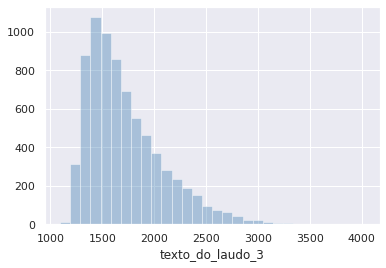

In [25]:
sns.set(color_codes=True)
comment_len = df.texto_do_laudo_3.str.len()
sns.distplot(comment_len, kde=False, bins=30, color="steelblue")

In [26]:
print('average sentence length: ', df.texto_do_laudo_3.str.split().str.len().mean())
print('stdev sentence length: ', df.texto_do_laudo_3.str.split().str.len().std())

average sentence length:  200.0512579039419
stdev sentence length:  43.800883789176616


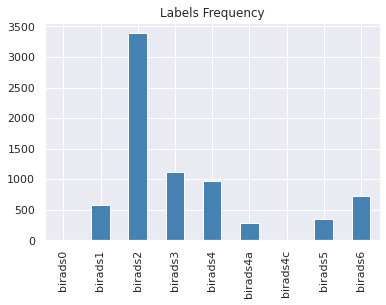

In [27]:
train_labels = df[['birads0', 'birads1', 'birads2', 'birads3', 'birads4', 'birads4a', 'birads4c', 'birads5', 'birads6']]
label_count = train_labels.sum()
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

In [28]:
cols = df.columns
label_cols = list(cols[2:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['birads0', 'birads1', 'birads2', 'birads3', 'birads4', 'birads4a', 'birads4c', 'birads5', 'birads6']


In [29]:
print('Count of 1 per label: \n', df[label_cols].sum(), '\n') # Label counts, may need to downsample or upsample
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

Count of 1 per label: 
 birads0       10
birads1      586
birads2     3387
birads3     1115
birads4      971
birads4a     280
birads4c       9
birads5      352
birads6      723
dtype: int64 

Count of 0 per label: 
 birads0     7423
birads1     6847
birads2     4046
birads3     6318
birads4     6462
birads4a    7153
birads4c    7424
birads5     7081
birads6     6710
dtype: int64


O conjunto de dados será convertido em tokens e depois dividido em conjuntos de treinamento e validação. Um novo conjunto de teste separado será carregado para inferência e avaliação do modelo.

In [30]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [31]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,id,texto_do_laudo_3,birads0,birads1,birads2,birads3,birads4,birads4a,birads4c,birads5,birads6,one_hot_labels
0,1665,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,8537,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,1906,ressonancia magnetica mamaria indicacao clini...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,2856,ressonancia magnetica mamaria indicacao clini...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,7062,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [32]:
labels = list(df.one_hot_labels.values)
comments = list(df.texto_do_laudo_3.values)

O processo de tokenização pode ser diferente para cada modelo Transformer, por isso é preciso carregar o tokenizer correspondente ao modelo a ser utilizado de forma específica. Alguns exemplos de tokenizers pré-treinados disponíveis no HuggingFace são:

```
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```


Aqui é aplicada uma extensão máxima de 500 tokens por laudo emitido. 

In [33]:
max_length = 500
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [34]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [35]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [36]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

## 3 - Treinamento

Para monitorar o desempenho do classificador, 10% dos dados de entrada será utilizado como um conjunto de validação. Para ter certeza de que todas as classes aparecerão no conjunto de validação, o parâmetro "stratify" será utilizado. 



In [37]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


Além disso, serão criados carregadores de dados PyTorch para carregar os dados para treinamento e validação.

In [38]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. 
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [39]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

### Configuração do modelo e parâmetros

Utilizaremos o BertForSequenceClassification. Cada um destes modelo já contém uma única camada dense para classificação.

```
BERT:
model = BertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=num_labels)

```

In [40]:
# Load model, the pretrained model will include a single linear classification layer on top for classification. 
model = BertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=num_labels)
model.cuda()

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Aqui é utilizado um otimizador AdamW, cujos parâmetros podem ser configurados de diferentes maneiras. A configuração utilizada aqui foi recomendada pelo modelo de referência, mas outras combinações podem ser testadas, inclusive o próprio default do otimizador. 


In [41]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [42]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

### Treinando o modelo

Será utilizada a métrica F1 para monitorar o desempenho do treinamento ao longo das épocas e a “Entropia cruzada binária com logits” como função de perda. 

Para tanto, os valores de saída do modelo deverão passar por uma função sigmóide (com saídas entre [0, 1] e limitando-os em 0,50 para gerar as previsões que serão utilizadas para avaliação do modelo final. 

In [43]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    
    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss() 
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.18610604820615004


Epoch:  25%|██▌       | 1/4 [10:52<32:37, 652.45s/it]

F1 Validation Accuracy:  79.74594213126323
Flat Validation Accuracy:  75.94086021505376
Train loss: 0.08796921349937271


Epoch:  50%|█████     | 2/4 [21:49<21:49, 654.97s/it]

F1 Validation Accuracy:  87.61002031144211
Flat Validation Accuracy:  86.4247311827957
Train loss: 0.06625023629380615


Epoch:  75%|███████▌  | 3/4 [32:45<10:55, 655.48s/it]

F1 Validation Accuracy:  89.01098901098902
Flat Validation Accuracy:  86.69354838709677
Train loss: 0.053914618046938693


Epoch: 100%|██████████| 4/4 [43:40<00:00, 655.07s/it]

F1 Validation Accuracy:  89.76271186440678
Flat Validation Accuracy:  88.30645161290323


In [44]:
torch.save(model.state_dict(), 'bert_model_birads')

In [45]:
test = df[['id','texto_do_laudo_3']]

In [46]:
test_labels = df[['id','birads0','birads1','birads2','birads3','birads4','birads4a','birads4c','birads5','birads6']]

## 4 - Avaliando o modelo

### Dados de teste

In [47]:
test_df = test
test_labels_df = test_labels
test_df = test_df.merge(test_labels_df, on='id', how='left')
test_label_cols = list(test_df.columns[2:])
print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
test_df.head()

Null values:  False
Same columns between train and test:  True


,id,texto_do_laudo_3,birads0,birads1,birads2,birads3,birads4,birads4a,birads4c,birads5,birads6
0,1665,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0
1,8537,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0
2,1906,ressonancia magnetica mamaria indicacao clini...,0,0,0,0,0,0,0,0,1
3,2856,ressonancia magnetica mamaria indicacao clini...,0,0,0,0,1,0,0,0,0
4,7062,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0


In [48]:
list(test_df.columns[2:])

['birads0',
 'birads1',
 'birads2',
 'birads3',
 'birads4',
 'birads4a',
 'birads4c',
 'birads5',
 'birads6']

In [49]:
#test_df = test_df[~test_df[test_label_cols].eq(1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

,id,texto_do_laudo_3,birads0,birads1,birads2,birads3,birads4,birads4a,birads4c,birads5,birads6,one_hot_labels
0,1665,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,8537,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,1906,ressonancia magnetica mamaria indicacao clini...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,2856,ressonancia magnetica mamaria indicacao clini...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,7062,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [50]:
test_df.head()

,id,texto_do_laudo_3,birads0,birads1,birads2,birads3,birads4,birads4a,birads4c,birads5,birads6,one_hot_labels
0,1665,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,8537,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,1906,ressonancia magnetica mamaria indicacao clini...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,2856,ressonancia magnetica mamaria indicacao clini...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,7062,ressonancia magnetica mamaria indicacao clini...,0,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [51]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.texto_do_laudo_3.values)

In [52]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

In [54]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

### Predição

In [55]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

De forma similar ao que foi realizado durante a validação do modelo, aqui foi estabelecido um threshold de 0,50 para a saída da função sigmóide, que varia no intervalo [0, 1].

In [56]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro',zero_division=1))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.9188161824599511
Test Flat Accuracy:  0.9082470065922239 

              precision    recall  f1-score   support

     birads0       0.00      0.00      0.00        10
     birads1       1.00      0.97      0.98       586
     birads2       0.99      0.98      0.99      3387
     birads3       0.95      0.97      0.96      1115
     birads4       0.86      0.95      0.90       971
    birads4a       1.00      0.70      0.83       280
    birads4c       0.00      0.00      0.00         9
     birads5       0.51      0.79      0.62       352
     birads6       0.93      0.55      0.70       723

   micro avg       0.93      0.91      0.92      7433
   macro avg       0.69      0.66      0.66      7433
weighted avg       0.94      0.91      0.92      7433
 samples avg       0.91      0.91      0.91      7433



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Salvando Modelo**

In [ ]:
path = '/content/'
torch.save(model, path)
saved_model = torch.load(path)

In [57]:
# saving the fine tuned model & tokenizer
model_path = "model_birads"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('model_birads/tokenizer_config.json',
 'model_birads/special_tokens_map.json',
 'model_birads/vocab.txt',
 'model_birads/added_tokens.json')